# INTRODUCTION
Glaucoma, a leading cause of blindness, damages the optic nerve. Early detection is vital, but traditional methods have limitations. This project explores using Convolutional Neural Networks (CNNs), powerful image recognition algorithms, to analyze retinal images and automatically detect glaucoma

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import DenseNet201, densenet
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.metrics import CohenKappa, F1Score
import tensorflow as tf
import os
import numpy as np
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
ROOT_DIRECTORY = '/content/drive/kaggle/input/fundus-pytorch'
LR = 0.0001
epochs = 20
fine_tuning_epochs = 20
total_epochs = epochs + fine_tuning_epochs

# Read images

In [ ]:
def read_dataset(path):
    datagen = ImageDataGenerator(rescale = 1./255)

    train_dataset = datagen.flow_from_directory(os.path.join(path, "train"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    test_dataset = datagen.flow_from_directory(os.path.join(path, "test"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')
    val_dataset = datagen.flow_from_directory(os.path.join(path, "val"), target_size = TARGET_SIZE, batch_size = BATCH_SIZE, class_mode = 'binary')

    return train_dataset, test_dataset, val_dataset

# TRAIN, TEST AND VALIDATION DATA COLLECTION(FUNDUS_PYTORCH)

In [ ]:
train_dataset, test_dataset, val_dataset = read_dataset(ROOT_DIRECTORY)

Found 8621 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.


# Sample Images and Labels from Glaucoma Training Data


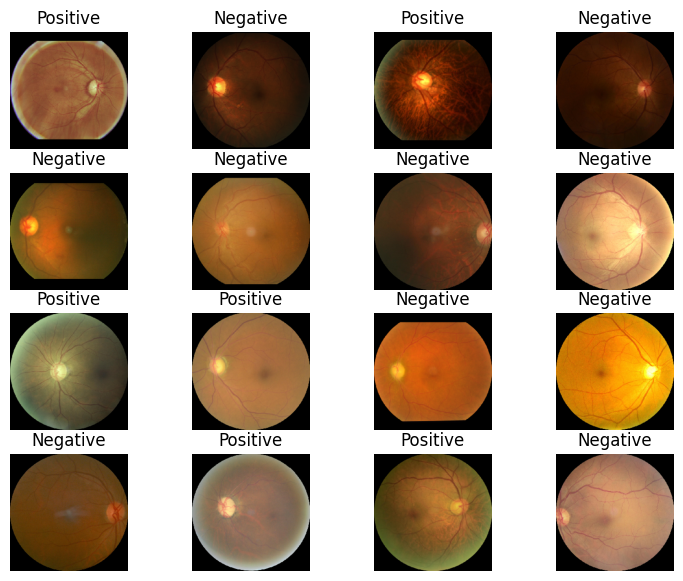

In [ ]:
batch = next(train_dataset) #Retrive images from train dataset
images, labels = batch  #Un-packing
n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize = (9, 7))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(images[i * n_cols + j])
        ax[i][j].set_title("Positive" if labels[i * n_cols + j] == 1.0 else "Negative")
        ax[i][j].axis("off")
plt.show()

# Building, Compiling, and Fine-Tuning a DenseNet201Glaucoma Detection Model


In [ ]:
strategy = tf.distribute.MirroredStrategy() # It Enables distributed training across multiple GPUs on a single machine.

with strategy.scope():
    print("Building model...\n")
    base_model = DenseNet201(include_top = False, weights = 'imagenet', input_shape = TARGET_SIZE + (3,))

    base_model.trainable = False #freezes the pre-trained weights of the base model

    model = tf.keras.Sequential()

    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

    print("Finished!\n")

    model.summary()

    metrics = [
        tf.keras.metrics.TruePositives(name = 'tp'),
        tf.keras.metrics.TrueNegatives(name = 'tn'),
        tf.keras.metrics.FalsePositives(name = 'fp'),
        tf.keras.metrics.FalseNegatives(name = 'fn'),
        tf.keras.metrics.BinaryAccuracy(name = 'acc'),
        tf.keras.metrics.Recall(name = 'r'),
        tf.keras.metrics.Precision(name = 'p'),
        F1Score(num_classes = 2, threshold = 0.5, average='micro', name = 'F1'),
        CohenKappa(num_classes = 2, name = 'Kappa')
    ]

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor = 0.3)]

    print("Compiling...\n")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = metrics,
    )
    print("Finished!\n")

    print("Fitting...\n")
    history_fit = model.fit(
        train_dataset,
        validation_data = val_dataset,
        batch_size = BATCH_SIZE,
        epochs = epochs,
        verbose = 1,
        callbacks = callbacks,
        shuffle = True,
        initial_epoch = 0,
    )
    print("Finished!\n")

    print("Initing fine-tuning...\n")
    #fine tuning
    base_model.trainable = True #Unfreezes the pre-trained weights in the base model

    for layer in base_model.layers[:200]:
        layer.trainable = False

    model.summary()

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LR / 10),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = metrics,
    )

    print("Fitting...\n")
    history_fine_tuning = model.fit(
        train_dataset,
        validation_data = val_dataset,
        batch_size = BATCH_SIZE,
        epochs = total_epochs,
        verbose = 1,
        callbacks = callbacks,
        shuffle = True,
        initial_epoch = fine_tuning_epochs,
    )

    print("Finished!\n")

Building model...

74836368/74836368 [==============================] - 0s 0us/step
Finished!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)           

# Merging Training and Fine-Tuning History for Evaluation

In [ ]:
for (_, element1), (_, element2) in zip(history_fit.history.items(), history_fine_tuning.history.items()):
    element1.extend(element2)

# Visualizing Training and Validation Metrics Across Training Phases

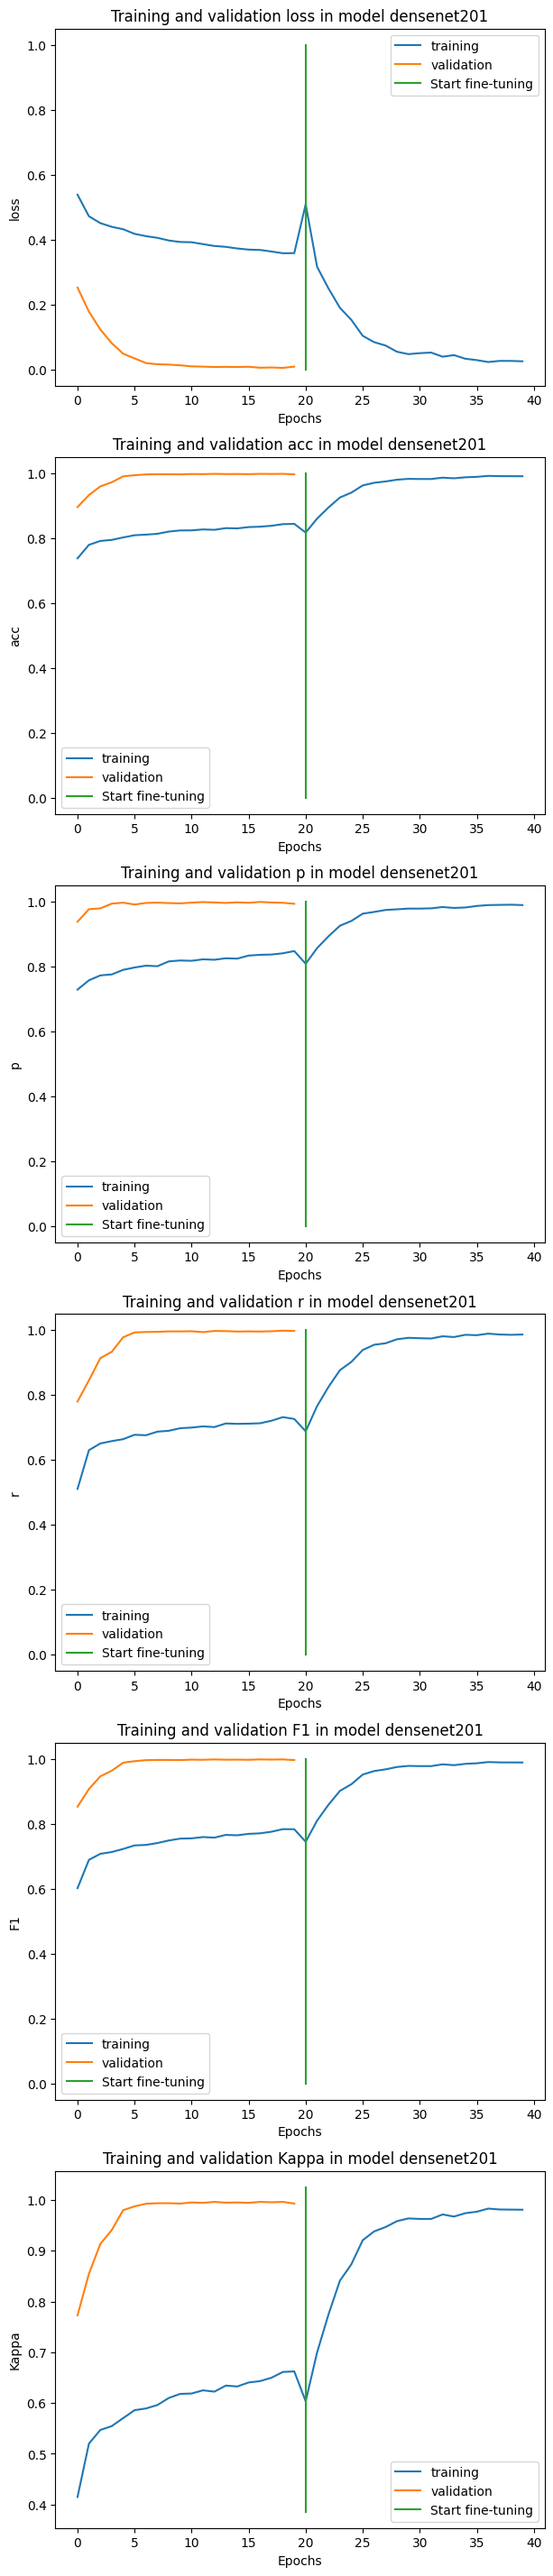

In [ ]:
plot_metrics = ['loss', 'acc', 'p', 'r', 'F1', 'Kappa']
fig, ax = plt.subplots(len(plot_metrics), 1, figsize = (7, 36))

for i, metric in enumerate(plot_metrics):
    ax[i].plot(history_fit.history[metric], label = 'training')
    ax[i].plot(history_fine_tuning.history['val_' + metric], label = 'validation')
    ax[i].plot([epochs, epochs], plt.ylim(), label = 'Start fine-tuning')
    ax[i].set_title(f"Training and validation {metric} in model {base_model.name}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend()

plt.show()

# Glaucoma Model Evaluation on Test Dataset

In [ ]:
results = model.evaluate(test_dataset)

180/180 [==============================] - 53s 294ms/step - loss: 0.0075 - tp: 1120.0000 - tn: 1746.0000 - fp: 8.0000 - fn: 0.0000e+00 - acc: 0.9972 - r: 1.0000 - p: 0.9929 - F1: 0.9964 - Kappa: 0.9942


In [ ]:
confusion_matrix = [
    [results[2], results[4]],
    [results[3], results[1]],
]

print(confusion_matrix)

[[1746.0, 0.0], [8.0, 1120.0]]


# Extracting Key Evaluation Metrics from Model Results

In [ ]:
result_metrics = [results[0]] + results[5:]
print(result_metrics)

[0.007500586565583944, 0.9972164034843445, 1.0, 0.9929078221321106, 0.9964413046836853, 0.9941555857658386]


# Key Evaluation Metrics from Model Results

In [ ]:
for metric, value in zip(plot_metrics, result_metrics):
    print(f"{metric}: {value:.4f}", end = ' | ')

loss: 0.0075 | acc: 0.9972 | p: 1.0000 | r: 0.9929 | F1: 0.9964 | Kappa: 0.9942 | 

Text(50.722222222222214, 0.5, 'True Label')

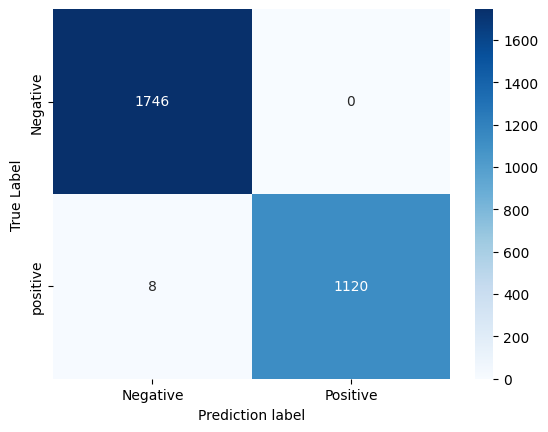

In [ ]:
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", cmap = 'Blues', xticklabels = ["Negative", "Positive"], yticklabels = ["Negative", "positive"])
plt.xlabel("Prediction label")
plt.ylabel("True Label")

In [ ]:
savedModel = model.to_json()
with open("model.json", 'w') as json_file:
    json_file.write(savedModel)

In [ ]:
(model.save("/content/keras_model.h5"))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predicting Glaucoma on a Retinal Image Using a Pre-trained Model

1/1 [==============================] - 3s 3s/step
Glaucoma was Positive


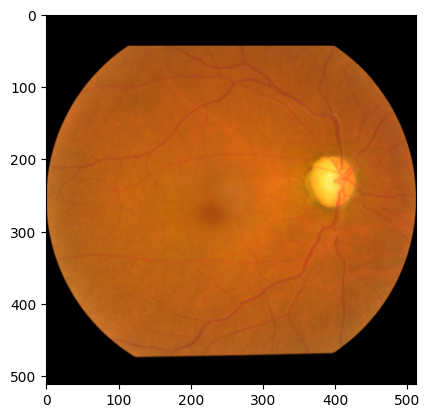

In [ ]:
# Load the image
model = tf.keras.models.load_model("/content/keras_model.h5")
image = tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/fundus-pytorch/val/1/BEH-10.png", target_size=(224, 224))

# Convert the image to a NumPy array
image = tf.keras.preprocessing.image.img_to_array(image)

# Expand the dimensions of the image to make it a batch
image = np.expand_dims(image, axis=0)

# Predict the class of the image
result = model.predict(image)
# Print the prediction
if result[0] > 0.5:
  print("Glaucoma was Positive")
else:
  print("Glaucoma was Negative")

# Print the original image
plt.imshow(tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/fundus-pytorch/val/1/BEH-10.png"))
plt.show()

1/1 [==============================] - 3s 3s/step
Glaucoma was Negative


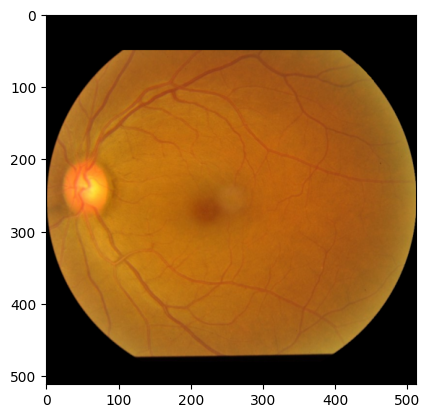

In [ ]:
# Load the image
model = tf.keras.models.load_model("/content/keras_model.h5")
image = tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/fundus-pytorch/val/0/BEH-218.png", target_size=(224, 224))

# Convert the image to a NumPy array
image = tf.keras.preprocessing.image.img_to_array(image)

# Expand the dimensions of the image to make it a batch
image = np.expand_dims(image, axis=0)

# Predict the class of the image
result = model.predict(image)
# Print the prediction
if result[0] > 0.5:
  print("Glaucoma was Positive")
else:
  print("Glaucoma was Negative")

# Print the original image
plt.imshow(tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/fundus-pytorch/val/0/BEH-218.png"))
plt.show()

1/1 [==============================] - 3s 3s/step
Glaucoma was Positive


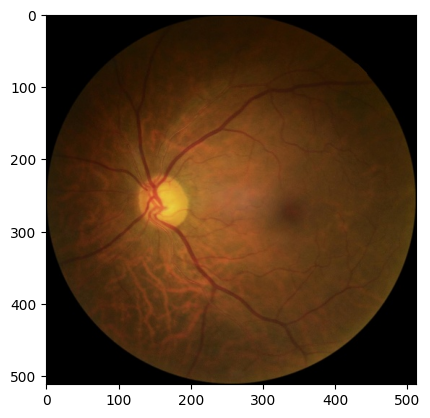

In [ ]:
# Load the image
model = tf.keras.models.load_model("/content/keras_model.h5")
image = tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/rectiffiedd/EyePACS-TRAIN-RG-2501.jpg", target_size=(224, 224))

# Convert the image to a NumPy array
image = tf.keras.preprocessing.image.img_to_array(image)

# Expand the dimensions of the image to make it a batch
image = np.expand_dims(image, axis=0)

# Predict the class of the image
result = model.predict(image)
# Print the prediction
if result[0] > 0.5:
  print("Glaucoma was Positive")
else:
  print("Glaucoma was Negative")

# Print the original image
plt.imshow(tf.keras.preprocessing.image.load_img("/content/drive/kaggle/input/rectiffiedd/EyePACS-TRAIN-RG-2501.jpg"))
plt.show()

# Streamlit Web App for Glaucoma Image Classification

In [1]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [2]:
%%writefile Glaucomaprediction.py
# Import necessary libraries
import streamlit as st
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import base64

# Load the model
model = tf.keras.models.load_model("/content/keras_model.h5")

import streamlit as st
import base64

with open("/content/background.PNG", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

st.markdown(
    f"""
    <style>
    .stApp {{
        background-image: url(data:image/png;base64,{encoded_string});
        background-size: cover;
    }}
    </style>
    """,
    unsafe_allow_html=True,
)

# Define the function to classify an image
def classify_image(image):
  # Preprocess the image
  image = Image.open(image)
  image = image.resize((224, 224))
  image = np.expand_dims(image, axis=0)
  image = image / 255.0

  # Predict the class of the image
  result = model.predict(image)

  # Return the prediction
  if result[0][0] > 0.5:
    return "Glaucoma was Positive"
  else:
    return "Glaucoma was Negative"

# Define the main function of the web app
def main():
  # Create a title for the web app
  st.title("Glaucoma Classification Web App")

  # Upload an image file
  image_file = st.file_uploader("Upload an image...", type=["png",'jpeg'])

  # Check if an image has been uploaded
  if image_file is not None:
    # Save the image file
    with open("image.png", "wb") as f:
      f.write(image_file.read())

    # Classify the image
    result = classify_image("image.png")

    # Display the classification result
    if result == "Glaucoma was Positive":
      st.write(f'<p style="color:darkred;">{result}</p>', unsafe_allow_html=True)
    else:
      st.write(f'<p style="color:darkgreen;">{result}</p>', unsafe_allow_html=True)

# Run the main function
if __name__ == "__main__":
  main()

Writing Glaucomaprediction.py


In [3]:
!wget -q -O - ipv4.icanhazip.com

34.138.49.249


In [4]:
! streamlit run Glaucomaprediction.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.138.49.249:8501

npx: installed 22 in 5.624s
your url is: https://yellow-ends-sing.loca.lt
2024-06-19 01:28:16.585098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 01:28:16.585175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 01:28:16.587174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 01:28:16.599902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

# Conclusion
The model achieves high accuracy (99%) on glaucoma classification tasks, indicating strong potential. To ensure real-world effectiveness, evaluation on unseen data and collaboration with medical professionals are essential. A Streamlit website deployment allows for sharing and exploration, paving the way for a valuable diagnostic aid in the future.